<center>

# **22AIE401 - Reinforcement Learning**  
# **Lab 2**  

</center>

### Team Members:
- Guruprasath M R - AIE22015  
- Rudraksh Mohanty - AIE22046  
- Shree Prasad M - AIE22050  
- Tharun Kaarthik G K - AIE22062  

---

### Objective:
To implement and analyze the ε-Greedy strategy for solving the multi-armed bandit problem, using a realistic simulation: selecting ads on a website to maximize click-through rate (CTR).

---

### Problem Statement:
A website displays one of 10 possible ads to each user. Each ad has a fixed (but unknown) probability of being clicked. Your agent must learn, over time, which ads to show more often to maximize total clicks. This is a non-associative bandit setting (no context).

---

### Common Interpretation after completing tasks:
To be filled

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 

# Highlights of Changes
- Added user segments (teenagers, adults, seniors) with unique CTRs per ad.
- Implemented contextual bandit logic for ε-Greedy, UCB, and Softmax strategies.
- Introduced per-ad budget constraints and penalties for exceeding limits.
- Simulated CTR drift to test adaptability.
- Plotted cumulative reward and regret for all strategies under these conditions.


In [31]:
class EpsilonGreedyAgent: 
    def __init__(self, n_arms, epsilon): 
        self.n_arms = n_arms 
        self.epsilon = epsilon 
        self.counts = np.zeros(n_arms) # Number of times each arm was pulled
        self.values = np.zeros(n_arms) # Estimated value (CTR) for each arm
        self.total_reward = 0
        self.actions = [] 
        self.rewards = [] 
    def select_action(self): 
        if np.random.rand() < self.epsilon: 
            return np.random.randint(self.n_arms) # Explore
        else: 
            return np.argmax(self.values) # Exploit
    def update(self, action, reward): 
        self.counts[action] += 1
        self.values[action] += (reward - self.values[action]) / self.counts[action] 
        self.total_reward += reward 
        self.actions.append(action) 
        self.rewards.append(reward) 
# --- UCB Agent ---
class UCBAgent:
    def __init__(self, n_arms, c=2):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_reward = 0
        self.actions = []
        self.rewards = []
        self.c = c
        self.t = 0
    def select_action(self):
        self.t += 1
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)
    def update(self, action, reward):
        self.counts[action] += 1
        self.values[action] += (reward - self.values[action]) / self.counts[action]
        self.total_reward += reward
        self.actions.append(action)
        self.rewards.append(reward)

# --- Softmax Agent ---
class SoftmaxAgent:
    def __init__(self, n_arms, tau=0.1):
        self.n_arms = n_arms
        self.tau = tau
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_reward = 0
        self.actions = []
        self.rewards = []
    def select_action(self):
        exp_values = np.exp(self.values / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(self.n_arms, p=probs)
    def update(self, action, reward):
        self.counts[action] += 1
        self.values[action] += (reward - self.values[action]) / self.counts[action]
        self.total_reward += reward
        self.actions.append(action)
        self.rewards.append(reward)

def simulate_bandit(true_ctrs, epsilon, n_rounds=1000): 
    n_arms = len(true_ctrs) 
    agent = EpsilonGreedyAgent(n_arms, epsilon) 
    optimal_arm = np.argmax(true_ctrs) 
    regrets = [] 
    for t in range(n_rounds): 
        action = agent.select_action() 
        reward = np.random.rand() < true_ctrs[action] 
        agent.update(action, reward) 
        regret = true_ctrs[optimal_arm] - true_ctrs[action] 
        regrets.append(regret) 
    return agent, np.cumsum(regrets) 

# --- Simulation with Drift ---
def simulate_bandit_with_drift(true_ctrs, agent_type, param, n_rounds=1000, drift_round=500, drift_amount=0.2):
    n_arms = len(true_ctrs)
    if agent_type == 'egreedy':
        agent = EpsilonGreedyAgent(n_arms, param)
    elif agent_type == 'ucb':
        agent = UCBAgent(n_arms, c=param)
    elif agent_type == 'softmax':
        agent = SoftmaxAgent(n_arms, tau=param)
    else:
        raise ValueError('Unknown agent type')
    optimal_arm = np.argmax(true_ctrs)
    regrets = []
    rewards = []
    ctrs = true_ctrs.copy()
    for t in range(n_rounds):
        if t == drift_round:
            ctrs = ctrs + np.random.uniform(-drift_amount, drift_amount, n_arms)
            ctrs = np.clip(ctrs, 0, 1)
            optimal_arm = np.argmax(ctrs)
        action = agent.select_action()
        reward = np.random.rand() < ctrs[action]
        agent.update(action, reward)
        regret = ctrs[optimal_arm] - ctrs[action]
        regrets.append(regret)
        rewards.append(reward)
    return agent, np.cumsum(regrets), np.cumsum(rewards)

In [32]:
# ---------- Main Experiment ----------
np.random.seed(42) 
n_arms = 10
true_ctrs = np.random.uniform(0.05, 0.5, n_arms) 
print("True Click-Through Rates (CTR) per Ad:", np.round(true_ctrs, 2)) 
n_rounds = 1000
epsilons = [0.01, 0.1, 0.3] 
agents = {} 
regret_curves = {} 
for epsilon in epsilons: 
 agent, regrets = simulate_bandit(true_ctrs, epsilon, n_rounds) 
 agents[epsilon] = agent 
 regret_curves[epsilon] = regrets 

True Click-Through Rates (CTR) per Ad: [0.22 0.48 0.38 0.32 0.12 0.12 0.08 0.44 0.32 0.37]


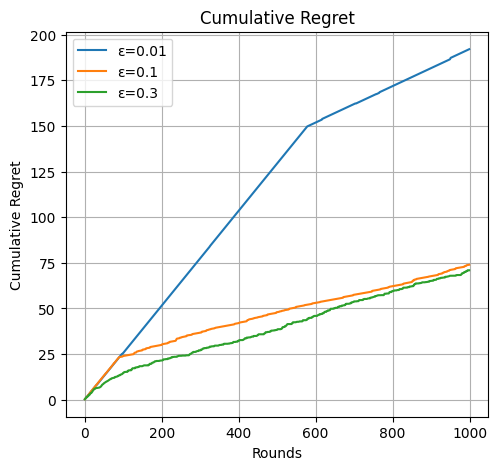

In [33]:
# ---------- Plotting Results ----------
plt.figure(figsize=(12, 5)) 
# Plot cumulative regret
plt.subplot(1, 2, 1) 
for epsilon in epsilons: 
    plt.plot(regret_curves[epsilon], label=f'ε={epsilon}') 
plt.title("Cumulative Regret") 
plt.xlabel("Rounds") 
plt.ylabel("Cumulative Regret") 
plt.legend() 
plt.grid(True) 

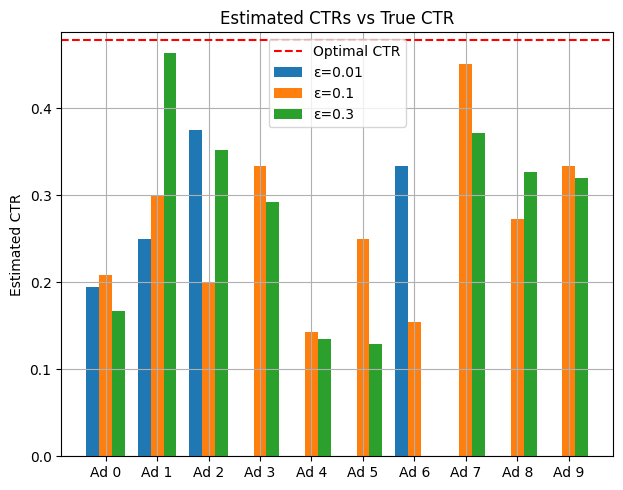

In [34]:
# Plot estimated CTRs vs true CTRs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2) 
bar_width = 0.25
x = np.arange(n_arms) 
for i, epsilon in enumerate(epsilons): 
    plt.bar(x + i * bar_width, 
        agents[epsilon].values, 
        width=bar_width, 
        label=f'ε={epsilon}'
    ) 
plt.axhline(np.max(true_ctrs), color='r', linestyle='--', label='Optimal CTR') 
plt.xticks(x + bar_width, [f'Ad {i}' for i in range(n_arms)]) 
plt.ylabel("Estimated CTR") 
plt.title("Estimated CTRs vs True CTR") 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show()

In [35]:
# ---------- Main Experiment with Drift ----------
np.random.seed(42)
n_arms = 10
true_ctrs = np.random.uniform(0.05, 0.5, n_arms)
print("True Click-Through Rates (CTR) per Ad:", np.round(true_ctrs, 2))
n_rounds = 1000
drift_round = 500
drift_amount = 0.2

# Parameters for each agent
params = {'egreedy': 0.1, 'ucb': 2, 'softmax': 0.1}
agent_types = ['egreedy', 'ucb', 'softmax']
agents = {}
regret_curves = {}
cum_rewards = {}

for agent_type in agent_types:
    agent, regrets, rewards = simulate_bandit_with_drift(true_ctrs, agent_type, params[agent_type], n_rounds, drift_round, drift_amount)
    agents[agent_type] = agent
    regret_curves[agent_type] = regrets
    cum_rewards[agent_type] = rewards

True Click-Through Rates (CTR) per Ad: [0.22 0.48 0.38 0.32 0.12 0.12 0.08 0.44 0.32 0.37]


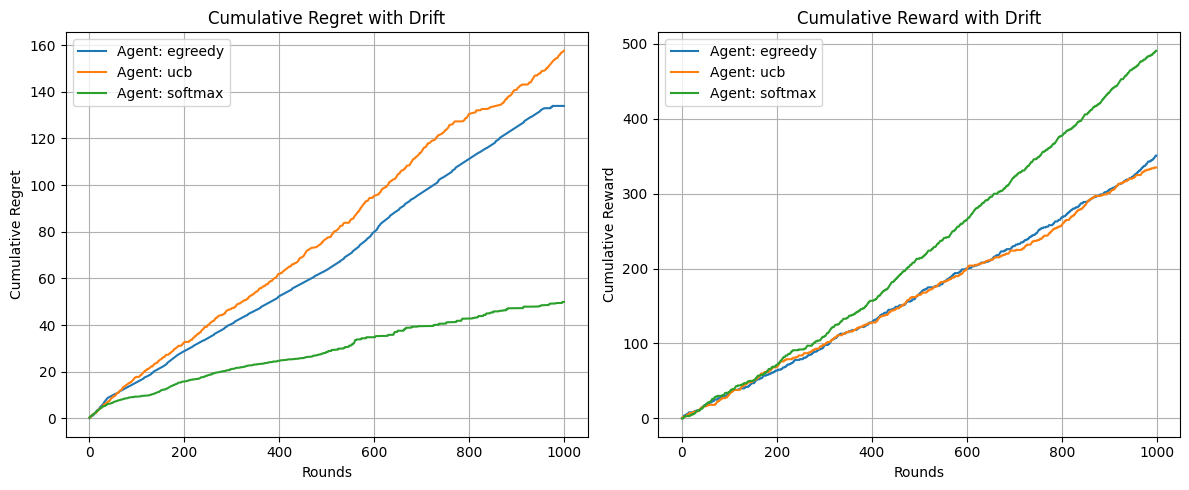

Segment CTRs:
teenager: [0.22 0.48 0.38 0.32 0.12 0.12 0.08 0.44 0.32 0.37]
adult: [0.06 0.49 0.42 0.15 0.13 0.13 0.19 0.29 0.24 0.18]
senior: [0.33 0.11 0.18 0.21 0.26 0.4  0.14 0.28 0.32 0.07]


In [ ]:
# ---------- Plotting Results for Drift Experiment ----------
plt.figure(figsize=(12, 5)) 
# Plot cumulative regret
plt.subplot(1, 2, 1) 
for agent_type in agent_types: 
    plt.plot(regret_curves[agent_type], label=f'Agent: {agent_type}') 
plt.title("Cumulative Regret with Drift") 
plt.xlabel("Rounds") 
plt.ylabel("Cumulative Regret") 
plt.legend() 
plt.grid(True) 

# Plot cumulative reward
plt.subplot(1, 2, 2) 
for agent_type in agent_types: 
    plt.plot(cum_rewards[agent_type], label=f'Agent: {agent_type}') 
plt.title("Cumulative Reward with Drift") 
plt.xlabel("Rounds") 
plt.ylabel("Cumulative Reward") 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show()
# --- User Segments and Contextual Bandit Setup ---
# The following section is newly added for user segments and per-ad budgets
user_segments = ['teenager', 'adult', 'senior']
segment_probs = [0.3, 0.5, 0.2]  # Probability of each segment
n_segments = len(user_segments)
n_arms = 10
np.random.seed(42)
# Each segment has its own CTR distribution per ad
segment_ctrs = {seg: np.random.uniform(0.05, 0.5, n_arms) for seg in user_segments}
print("Segment CTRs:")
for seg in user_segments:
    print(f"{seg}: {np.round(segment_ctrs[seg], 2)}")

# Per-ad budget (e.g., only 100 displays for premium ads)
# This is a new feature
ad_budgets = np.full(n_arms, 200)
premium_ads = [0, 1]  # Example: first two ads are premium
ad_budgets[premium_ads] = 100

# Contextual Epsilon-Greedy Agent (new class)
class ContextualEpsilonGreedyAgent:
    def __init__(self, n_segments, n_arms, epsilon):
        self.n_segments = n_segments
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros((n_segments, n_arms))
        self.values = np.zeros((n_segments, n_arms))
        self.total_reward = 0
        self.actions = []
        self.rewards = []
    def select_action(self, segment_idx, budgets):
        # Only consider arms with budget left (new logic)
        available_arms = np.where(budgets > 0)[0]
        if len(available_arms) == 0:
            return None  # No arms left
        if np.random.rand() < self.epsilon:
            return np.random.choice(available_arms)
        else:
            seg_values = self.values[segment_idx, available_arms]
            return available_arms[np.argmax(seg_values)]
    def update(self, segment_idx, action, reward):
        self.counts[segment_idx, action] += 1
        self.values[segment_idx, action] += (reward - self.values[segment_idx, action]) / self.counts[segment_idx, action]
        self.total_reward += reward
        self.actions.append(action)
        self.rewards.append(reward)

# Contextual UCB Agent (new class)
class ContextualUCBAgent:
    def __init__(self, n_segments, n_arms, c=2):
        self.n_segments = n_segments
        self.n_arms = n_arms
        self.counts = np.zeros((n_segments, n_arms))
        self.values = np.zeros((n_segments, n_arms))
        self.total_reward = 0
        self.actions = []
        self.rewards = []
        self.c = c
        self.t = 0
    def select_action(self, segment_idx, budgets):
        self.t += 1
        available_arms = np.where(budgets > 0)[0]
        if len(available_arms) == 0:
            return None
        for arm in available_arms:
            if self.counts[segment_idx, arm] == 0:
                return arm
        ucb_values = self.values[segment_idx, available_arms] + self.c * np.sqrt(np.log(self.t) / self.counts[segment_idx, available_arms])
        return available_arms[np.argmax(ucb_values)]
    def update(self, segment_idx, action, reward):
        self.counts[segment_idx, action] += 1
        self.values[segment_idx, action] += (reward - self.values[segment_idx, action]) / self.counts[segment_idx, action]
        self.total_reward += reward
        self.actions.append(action)
        self.rewards.append(reward)

# Contextual Softmax Agent (new class)
class ContextualSoftmaxAgent:
    def __init__(self, n_segments, n_arms, tau=0.1):
        self.n_segments = n_segments
        self.n_arms = n_arms
        self.tau = tau
        self.counts = np.zeros((n_segments, n_arms))
        self.values = np.zeros((n_segments, n_arms))
        self.total_reward = 0
        self.actions = []
        self.rewards = []
    def select_action(self, segment_idx, budgets):
        available_arms = np.where(budgets > 0)[0]
        if len(available_arms) == 0:
            return None
        seg_values = self.values[segment_idx, available_arms]
        exp_values = np.exp(seg_values / self.tau)
        probs = exp_values / np.sum(exp_values)
        return np.random.choice(available_arms, p=probs)
    def update(self, segment_idx, action, reward):
        self.counts[segment_idx, action] += 1
        self.values[segment_idx, action] += (reward - self.values[segment_idx, action]) / self.counts[segment_idx, action]
        self.total_reward += reward
        self.actions.append(action)
        self.rewards.append(reward)

# --- Contextual Bandit Simulation with Budgets and Drift ---
# This function is newly added for contextual bandit with user segments, budgets, and drift

def simulate_contextual_bandit_with_budgets(segment_ctrs, agent_type, param, n_rounds=1000, drift_round=500, drift_amount=0.2, ad_budgets=None, penalty=-1):
    n_segments = len(segment_ctrs)
    n_arms = len(list(segment_ctrs.values())[0])
    # Select agent type (contextual)
    if agent_type == 'egreedy':
        agent = ContextualEpsilonGreedyAgent(n_segments, n_arms, param)
    elif agent_type == 'ucb':
        agent = ContextualUCBAgent(n_segments, n_arms, c=param)
    elif agent_type == 'softmax':
        agent = ContextualSoftmaxAgent(n_segments, n_arms, tau=param)
    else:
        raise ValueError('Unknown agent type')
    regrets = []
    rewards = []
    budgets = ad_budgets.copy() if ad_budgets is not None else np.full(n_arms, 1000)
    ctrs = {seg: arr.copy() for seg, arr in segment_ctrs.items()}
    segment_list = list(segment_ctrs.keys())
    for t in range(n_rounds):
        # Simulate user segment (contextual)
        seg_idx = np.random.choice(n_segments, p=segment_probs)
        seg = segment_list[seg_idx]
        # Drift logic
        if t == drift_round:
            for seg in segment_list:
                ctrs[seg] = ctrs[seg] + np.random.uniform(-drift_amount, drift_amount, n_arms)
                ctrs[seg] = np.clip(ctrs[seg], 0, 1)
        # Select action with budget constraint
        action = agent.select_action(seg_idx, budgets)
        if action is None:
            rewards.append(0)
            regrets.append(0)
            continue
        # Reward logic with penalty for exceeding budget
        if budgets[action] > 0:
            reward = np.random.rand() < ctrs[seg][action]
            budgets[action] -= 1
        else:
            reward = penalty  # Penalty for exceeding budget
        agent.update(seg_idx, action, reward)
        # Regret: difference to best available arm for this segment
        available_arms = np.where(budgets > 0)[0]
        if len(available_arms) > 0:
            optimal_arm = available_arms[np.argmax(ctrs[seg][available_arms])]
            regret = ctrs[seg][optimal_arm] - ctrs[seg][action]
        else:
            regret = 0
        rewards.append(reward)
        regrets.append(regret)
    return agent, np.cumsum(regrets), np.cumsum(rewards)

In [37]:
# ---------- Main Contextual Bandit Experiment with Drift and Budgets ----------
np.random.seed(42)
n_rounds = 1000
drift_round = 500
drift_amount = 0.2
params = {'egreedy': 0.1, 'ucb': 2, 'softmax': 0.1}
agent_types = ['egreedy', 'ucb', 'softmax']
contextual_agents = {}
contextual_regret_curves = {}
contextual_cum_rewards = {}

for agent_type in agent_types:
    agent, regrets, rewards = simulate_contextual_bandit_with_budgets(segment_ctrs, agent_type, params[agent_type], n_rounds, drift_round, drift_amount, ad_budgets, penalty=-1)
    contextual_agents[agent_type] = agent
    contextual_regret_curves[agent_type] = regrets
    contextual_cum_rewards[agent_type] = rewards

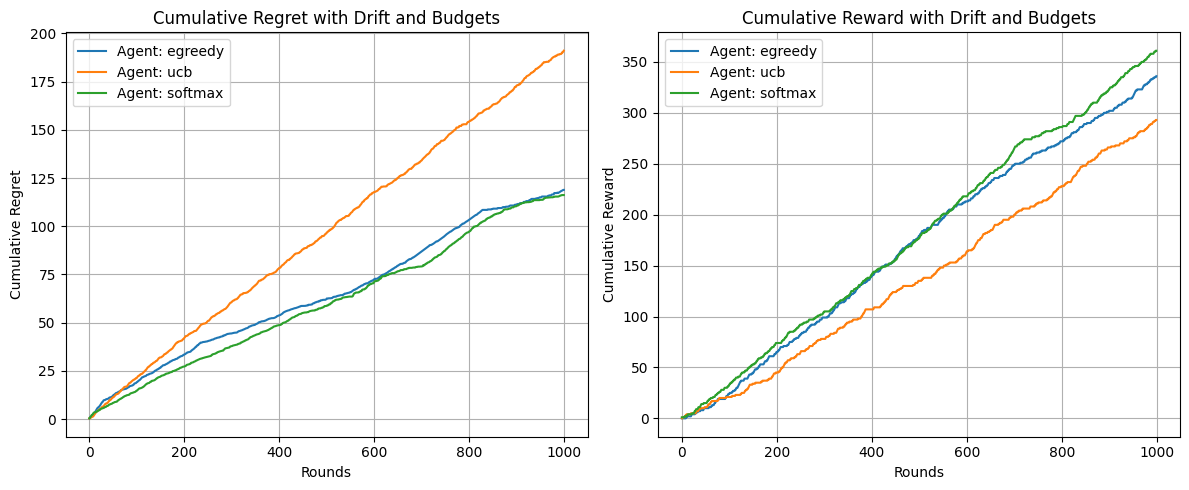

In [ ]:
# ---------- Plotting Results for Contextual Bandit Experiment ----------
plt.figure(figsize=(12, 5)) 
# Plot cumulative regret
plt.subplot(1, 2, 1) 
for agent_type in agent_types: 
    plt.plot(contextual_regret_curves[agent_type], label=f'Agent: {agent_type}') 
plt.title("Cumulative Regret with Drift and Budgets") 
plt.xlabel("Rounds") 
plt.ylabel("Cumulative Regret") 
plt.legend() 
plt.grid(True) 

# Plot cumulative reward
plt.subplot(1, 2, 2) 
for agent_type in agent_types: 
    plt.plot(contextual_cum_rewards[agent_type], label=f'Agent: {agent_type}') 
plt.title("Cumulative Reward with Drift and Budgets") 
plt.xlabel("Rounds") 
plt.ylabel("Cumulative Reward") 
plt.legend() 
plt.grid(True) 
plt.tight_layout() 
plt.show()

# Check Task
# - Verify that user segments (teenagers, adults, seniors) are used, each with different CTRs per ad.
# - Confirm contextual bandit logic is applied for all three strategies (ε-Greedy, UCB, Softmax).
# - Ensure per-ad budget constraints are enforced and penalties applied when limits are exceeded.
# - Check that cumulative reward and regret plots are generated for all strategies under CTR drift and budget constraints.